## Modelling Correlation between Risks

* The estimate of default probabilities and their correlations is the most important issue in credit derivative valuation and credit risk management. 


* Default correlation measures the tendency of two companies to default at about the same time. 
    * For this there are two ways: using historical default data or using mathematical models, like copulas. 


* *Historical default data* played an important role in the estimation of default probabilities, but: 
    * default events are rare so there is very limited default data available;
    * historical data reflects the those default pattern only and it may not be a proper indicator of the future;
        * default probabilities estimate from historical data is difficult and inexact; 
        * to estimate default correlations with same data is even more difficult and more inexact. 


* *Mathematical models* don't rely on historical default data: is the way that is now used to estimate/apply correlations.

### Distribution Transformation

* Distribution transformation is used to transform a random variable PDF to a uniform distribution and vice versa (also called *probability integral transform* or *percentile-to-percentile transform*). 
    * This method involves computing the CDF or the quantile function of the original distribution.
    
$$\textrm{uniform_sample} \rightarrow \tt{distribution.ppf(uniform\_sample)} \rightarrow \textrm{distribution_sample}$$
$$\textrm{distribution_sample} \rightarrow \tt{distribution.cdf(distribution\_sample)} \rightarrow \textrm{uniform_sample}$$
    
#### Example

* $P(X)$ is the uniform distribution to convert it to standard normal distribution with zero mean and unit standard deviation $\mathcal{N}(0,1)$ just apply the inverse of normal CDF:
    * remember that the uniform samples can be interpreted as cumulative probabilities.

In [2]:
# make table uniform to gauss
from scipy.stats import norm

x_unif = [0.3, 0.5, 0.9, 0.99999]

for x in x_unif:
    print ("{:.05f} -> {:.4f}".format(x, norm.ppf(x)))

0.30000 -> -0.5244
0.50000 -> 0.0000
0.90000 -> 1.2816
0.99999 -> 4.2649


* $\tt{python}$ provides an easier way to apply such transformations: indeed it can be applied directly on the entire sample.
    * Given a sitribution object:
        * $\tt{rvs}$ method samples $\tt{size}$ times from it.
        * each other method (like $\tt{cdf}$ or $\tt{ppf}$) works on $\tt{numpy.array}$, a particular kind of list, allowing to avoid loop-cycles.

In [6]:
# sample from uniform
from scipy.stats import uniform

x_unif = uniform.rvs(size=10)
print (type(x_unif))
x_transf = norm.ppf(x_unif)
print (x_unif)
print (x_transf)

<class 'numpy.ndarray'>
[0.16546429 0.83629022 0.5656176  0.81587113 0.96457022 0.35379494
 0.24245933 0.71108937 0.97897189 0.60132219]
[-0.9722452   0.97932471  0.16522766  0.89974166  1.80637638 -0.37509491
 -0.69841346  0.55656998  2.03296346  0.25677092]


<img src="uniform_gauss.png">

* with a 2D plot we can get a sense of what is going on when using the inverse CDF transformation:

<img src="uniform_to_gauss_2d.png">

* It stretches the outer regions of the uniform to yield a normal distribution. 


* This technique can be used with any arbitrary (univariate) probability distributions, like for example t-Student or Gumbel.

In [4]:
# do the same with t-student
from scipy.stats import t

x_trans2 = t(4).ppf(x_unif)

<img src="uniform_tstudent_2d.png">

* To go from an arbitray distribution to uniform, just apply the inverse of the inverse CDF, which is the CDF itself...

In [5]:
# make uniform to gauss to uniform
x_trans3 = norm.ppf(x_unif)
x_unif2 = norm.cdf(x_trans3)

<img src="full_chain.png">

## Copula

* In probability theory a *copula* $\mathcal{C}(F_1, F_2, \ldots, F_n)$ is a multivariate cumulative distribution function whose marginal probability distributions (the probability distribution of each dimension) are uniform. 


* Copulas are used to describe dependencies between random variables.
    * widely used in quantitative finance to model risk. 
    
    
* Very popular since allow to easily model and estimate the distribution of random vectors by representing marginals and their correlation separately. 
    * A complicated problem can be split into many simpler components.

### Example Problem Case

* Imagine to measure two correlated variables: look at various rivers and for each one look at its maximum water level, and also count how many months each river caused flooding. 
    * For the probability distribution of the maximum level of the river we know that are *Gumbel* distributed;
    * while the number of floods can be modelled according to a *Beta* distribution.


* It's reasonable to assume that the two are correlated, however we don't know how we could model that correlated probability distribution. 
    * Above it was only specified the distributions of the individual variables, irrespective of the other one (i.e. the marginals), in reality we would like to study the joint distribution of both of these together. 


* Copulas allow to decompose a joint probability distribution into their marginals (which by definition have no correlation) and a function which couples (hence the name) them together.

#### Adding Correlation with Gaussian Copulas

* We know how to convert every PDF from and to a uniform distribution. 
    * So we can generate uniformly distributed data with the correlation we want (for simplicity we ara going to assume Gaussian correlation);
    * then transform the uniform marginals each into the desired distributions. 


* Let's sample from a multivariate normal (2D) with a 0.5 correlation.

In [10]:
# sample from multi-normal with corr
from scipy.stats import multivariate_normal

mvnorm = multivariate_normal(mean=[0, 0], cov=[[1, 0.5],
                                               [0.5 , 1]])

x = mvnorm.rvs(size=10000)

print (x[0:5, :])

[[-0.98096774 -1.09392014]
 [ 0.90299709 -0.38523323]
 [-1.00509964 -2.3151635 ]
 [-0.73534541 -0.99197424]
 [ 0.00415729 -0.07833814]]


* This particular $\tt{python}$ notation is called *slicing* of an array
    

* Imagine to have a 2D matrix: to access an element of the matrix it is necessary to specify two indices (the row and the column of the element)

In [16]:
import numpy as np

a = np.array([[1,2,3,4],[5,6,7,8], [9,10,11,12]])
print (a)
print("")
print (a[2][2])

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]]

11


* To access a range of values it is possible to specify the interval of indices inside square brackets

In [14]:
print (a[1][1:3])

[6 7]


* Finally to get an entire row (or column) it is enough to specify $\tt{:}$ (colon) as index

In [18]:
print (a[1][:]) 
print ("")
print (a[1][0:4]) # which is equivalent

[5 6 7 8]

[5 6 7 8]


<img src="multivariate_2d.png">

* Now tranform the marginals to uniform using the normal $\tt{cdf}$ function (again the method is smart enough to automatically transform each component. 

In [12]:
# convert each component
from scipy.stats import norm

x_unif = norm.cdf(x)

print (x_unif[0:5, :])

[[0.16330432 0.136995  ]
 [0.81673628 0.35003231]
 [0.15742444 0.01030199]
 [0.23106458 0.16060505]
 [0.50165851 0.46877954]]


<table>
    <tr>
        <td><img src="copula_2d.png" width=300></td>
        <td><img src="copula_3d.png" width=300></td>
    </tr>
</table>

* These plots are usually how copulas are visualized. 


* **Since we used a multivariate stadard normal to model correlation this is also called a Gaussian Copula.**


* Finally we can just transform the marginals from uniform to what we want (i.e. Gumbel and Beta in our river example): 

In [13]:
# convert again to gumbel e beta
from scipy.stats import gumbel_l, beta

gumbel = gumbel_l()
b = beta(a=4, b=10)

x1 = gumbel.ppf(x_unif[:][0])
x2 = b.ppf(x_unif[:][1])

* Just compare the scatter plot with correlation to the joint distribution of the same marginals without.

In [20]:
# sample from Gumbel
# sample from Beta
m1 = gumbel.rvs(size=10000)
m2 = b.rvs(size=10000)

<table>
    <tr>
        <td><img src="gumbel_beta_corr.png" width=300></td>
        <td><img src="gumbel_beta_uncorr.png" width=300></td>
    </tr>
</table>

* Using the uniform distribution as a common base for our transformations we can easily introduce correlations and flexibly construct complex probability distributions. 


* Clearly this is directly extendeable to higher dimensional distributions as well.


### Generate Correlated Distributions (Numerical Example)

* Generate a random vector $\mathbf{x}=(x_1, x_2,\ldots)$ from a multivariate distribution with the desired correlation;
* determine every $U_i(x_i)$ by applying $\tt{cdf}$ to each $x_i$;
* transform again each $U_i(x_i)$ to the desired marginal distributions using $\tt{ppf}$.


* Each component of $\mathbf{x}$ is now transformed as it was sampled from the desired marginals with the appropriate correlation.

#### Example

* Imagine three companies (A, B and C) with cumulative 2 years default probability of 10%.
    * Let’s compute the probabilities to have the three of them all defaulting within the next two years in the two cases: with independent and correlated default probabilities.


* **Independent probabilities**: the odds to get three defaults within two years is the product of the single probabilities, hence:

$$\mathbb{P}_{\mathrm{uncorr}}= 10\%\cdot 10\%\cdot 10\% = 0.1\%$$


* The verification in $\tt{python}$ can be done with the algorithm outlined above: 

In [14]:
# test default probabilities of three companies (no corr)
from scipy.stats import multivariate_normal, norm

mvnorm = multivariate_normal(mean=[0,0,0], cov=[[1, 0, 0],
                                                [0, 1, 0],
                                                [0, 0, 1]])
samples = 100000
success = 0.
x = mvnorm.rvs(size=samples)
x_unif = norm.cdf(x)

for v in x_unif:
    if max(v) < 0.1:
        success += 1
        
print (success/samples)

0.00098


* Repeat the same Monte Carlo experiment with perfectly correlated default probabilities:

In [15]:
# test default probabilities of three companies (perfect corr)
from scipy.stats import multivariate_normal, norm

mvnorm = multivariate_normal(mean=[0, 0, 0], cov=[[1, 0.9999, 0.9999],
                                                  [0.9999, 1, 0.9999],
                                                  [0.9999, 0.9999, 1]])
samples = 100000
success = 0.
x = mvnorm.rvs(size=samples)
x_unif = norm.cdf(x)

for v in x_unif:
    if max(v) < 0.1:
        success += 1
        
print (success/samples)

0.09827


* In this case the result is close to 10%.
    * Indeed being the three companies perfectly correlated either there is no default or three *simultaneous* defaults with 10% probability.

## Gaussian Copula Model (Analytical Solution)

* The first copulla model introduced was the *one-factor Gaussian*.
    * This model has, above all, the advantage that can be solved analytically.


* Consider a portfolio of $N$ bonds with known marginal issuer probabilities of default
    * $t_i$, the time of default of the $i^{th}$ company;
    * $Q_i(t)$, the cumulative probability that company $i$ will default before time $t$; that is, the probability that $t_i \le t$.


* To generate a one-factor model for the $t_i$ we define random variables 

$$X_i = a_i M + \sqrt{1-a_i^2}Z_i,\qquad i = 1, 2,\ldots, N$$

* where $M$ and the $Z_i$ are independent zero-mean unit-variance distributions (hence $X_i$ are also distributed with zero-mean and unit standard-deviation) and $-1 \le a_i \lt 1$.
    * Previous equation defines a correlation structure between the $X_i$ which depend on a single common factor $M$. 
    * The $Z_i$ term is usually called the idiosyncratic component of default


* The correlation between $X_i$ and $X_j$ is

$$\mathrm{Corr}(X_i, X_j) = \cfrac{\mathbb{E}[(X_i-\mu_i)(X_j-\mu_j)]}{\sigma_{i}\sigma_{j}} =\mathbb{E}[X_i X_j] = a_i a_j \mathbb{E}[M^2] = a_i a_j
$$

* where we just exploit the definition of $X_i$ and its properties.


* If $F_i$ is the CDF of $X_i$, with a percentile to percentile transformation we can map the $X_i$ to the $t_i$, so that $Q_i(t_i) = P(X_i\le x)=F_i(x)$.


* Therefore the point $X_i = x$ is transformed to $t_i = t$ where $x = F_i^{-1}[Q_i(t)]$:
   * *conditional* on $M$, the $N$ default events are independent. 

$$
\begin{split}
Q_i(t_i|M) = P(X_i\le x|M) &= P(a_i M + \sqrt{1-a_i^2}Z_i\le x|M) =\\
&= P\left(Z_i\le \cfrac{x-a_i M}{\sqrt{1-a_i^2}}\right)
=H_i\left(\cfrac{F^{-1}[Q_i(t_i)]-a_i M}{\sqrt{1-a_i^2}}\right)
\end{split}
$$

* where $H_i$ is the CDF of the $Z_i$.


* Since we are describing the Gaussian copula model we can specialize the previous equation as

$$
Q_i(t_i|M) = \Phi\left(\cfrac{\Phi^{-1}[Q_i(t_i)]-a_i M}{\sqrt{1-a_i^2}}\right)
$$

* where $\Phi$ denotes the standard normal CDF. 


* If $\mathcal{C}(t_1,\ldots,t_N)$ is the joint distribution of the default times of the $N$ bonds in the portfolio then

$$
\mathcal{C}(t_1,\ldots,t_N)=\Phi_{A}(\Phi^{-1}(Q_1(t_1)),\ldots,\Phi^{-1}(Q_N(t_N)))
$$

* where $A$ is the correlation matrix of the default probabilities, is the one factor Gaussian copula
    * one factor because there is only a random variable, $M$, which determines the correlation between $X_i$.


* Different distributions result in different copula models, and in different natures of the default dependence. 
    * For example, copulas where the \(M\) have heavy tails generate models where there is a
greater likelihood of a clustering of early defaults for several companies.

#### Standard Market Model

* Assume the following two assumptions are made:
    * all the companies have the same default intensity (hazard rates), i.e, $\lambda_i = \lambda$ (which means they all have the same default probabilities);
    * the pairwise default correlations are the same, i.e $a_i = a$; in other words the contribution of the market 	component $M$ is the same for all the companies and the correlation between any two companies is constant, $\rho = a^2$.


* Under these assumptions, given the market situation $M = m$, all the companies have the same cumulative default probability $Q_i(t_i|m)=\mathbb{P}(X_i \le x|m)$.

* With these assumptions the one factor model is also called *Market Standard Model*.

## Binomial Distribution

* The binomial distribution represents the discrete probability of independent events and each event has exactly two possible outcomes (e.g. toss of a coin).


* The binomial distribution answers to the question: what is the probability of exactly $k$ successes on $n$ repeated trials given that:
    * the number of observations or trials is fixed;
    * each observation or trial is independent (e.g. like in the coin toss, the previous toss doesn’t affect the following);
    * the probability of success is exactly the same from one trial to another (e.g. each coin toss has 50% chances to fall in heads or tails).

$$\mathrm{PMF_{binomial}} = \binom{n}{k} p^{k}(1-p)^{n-k} = \cfrac{n!}{k!(n−k)!} p^{k}(1-p)^{n-k}$$

In [17]:
# probability of tossing a coin 
from scipy.stats import binom
print (binom(10, 0.5).pmf(5))

0.24609375000000003


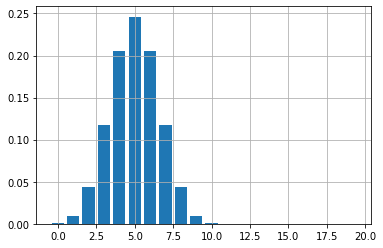

In [19]:
from matplotlib import pyplot as plt

x = range(20)
plt.bar(x, binom(10, 0.5).pmf(x))
plt.grid(True)
plt.show()

In [3]:
# probability of having more then 5 heads
b = binom(10, 0.5)

s = 0
for i in range(5, 11):
    s += b.pmf(i)
print (s)

0.6230468750000006


In [5]:
# compute as difference of cdfs or 1-cdf
print (b.cdf(10)-b.cdf(4))
print (1 - b.cdf(4))

0.6230468749999999
0.6230468749999999


#### Back to Gaussian Copula Model

* Let $l_{t|m}$ be the total defaults that have occurred by time $t$ conditional on the market condition $M = m$, then $l_{t|m}$ follows a binomial distribution (each default has the same probability and events are independent to each other once $M$ is fixed)

$$Q(l_{t|m} = j) = \cfrac{N!}{j!(N-j)!}Q^j_{t|m}(1-Q_{t|m})^{N-j},\qquad  j=0, 1, 2,\ldots,N$$


* To evaluate any function of $Q$, $g(Q(l_t))$, regardless the value of $M$ is necessary to average 

$$
g(Q(l_{t} = j)) = \int_{-\infty}^{\infty}{g(Q(l_{t|m} = j))\cdot f_M(m)dm}
$$

* where $f_M(m)$ is the PDF of $M$.

## Basket Default Swaps
* A basket default swap is a credit derivative on a portfolio of reference entities. 
    * The simplest basket default swaps are first-to-default, second-to-default...nth-to-default swaps. 


* Very similar to normal CDS except for the protection they offer:
    * a first-to-default swap provides insurance for only the first default happening;
    * a second-to-default swap provides insurance for only the second default...
    

* For example, in a nth-to-default swap, the seller does not make any payment to the protection buyer for the first $n-1$ defaulted entities, and makes it only for the
$n^{th}$ default. Once there has been this payment the swap terminates.


### n$^{th}$-to-default Basket Valuation 

* Assume the principals and expected recovery rates are the same for all underlying reference assets.


* The valuation procedure is similar to that for a regular CDS:
    * in CDS valuation based on the probability that a default occured between times $t_1$ and $t_2$. 
    * in basket based on the probability that the $n^{th}$ default was between times $t_1$ and $t_2$.


* The buyer of protection makes quarterly payments at a specified rate until the $n^{th}$ default occurs or the end of the life of the contract is reached. 


* In the event of the $n^{th}$ default occurring, the seller pays $F\cdot(1-R)$.


* The contract can be valued by calculating the expected present value of payments and the expected present value of payoffs. 

### $\tt{args}$ and $\tt{kwargs}$

* $\tt{args}$ and $\tt{kwargs}$ represent two useful ways of passing parameters to a function that is called by another function.

In [10]:
def runner(f, x, args):
    return f(x, *args)*2

def func(x, a, b, c):
    return a*x**2 + b*x + c

for v in range(3):
    print (runner(func, 2, args=(v, 1, 5)))

14
22
30


* $\tt{kwargs}$ works like $\tt{args}$ except that you have to pass a dictionary with as keys the names of the parameters. Also to expand it you have to use the double-star operator.

In [11]:
def runner(f, x, kwargs):
    return f(x, **kwargs)*2

for v in range(3):
    print (runner(func, 2, kwargs={"a":v, "c":5, "b":1}))

14
22
30


* compute the correlated default probability of each name according to 

$$Q(t|M) = \Phi\left(\cfrac{\Phi^{-1}[Q(t)]-\sqrt{\rho} M}{\sqrt{1-\rho}}\right)$$

* compute the probability to have at least j defaults using the binomial distribution

$$Q(l_{t|m} \ge j) = \sum_{k=j}^{N}\left[\cfrac{N!}{k!(N-k)!}Q(t|M)^k(1-Q(t|M))^{N-k}\right]$$

* create a **credit curve**, $CC(Q)$,  with those probabilities;
* re-use the $\tt{CreditDefaultSwap}$ class methods to compute NPV and breakeven rate (which depend on a discount curve and a previous credit curce), through integration of

$$ \mathrm{NPV}(DC, CC(Q)) = \int_{-\infty}^{\infty}{\mathrm{NPV}(DC, CC(Q)) f_M(m)dm} $$

#### Integration in Python

* To integrate a function $f$ in $\tt{python}$ we can use the $\tt{scipy.integrate.quad}$ which takes as input:
    * the function to integrate; 
    * the integration limits;
    * optional arguments of the integrand.

$$f(x) = \int_{-2}^{4}(ax^{3} + b)~dx$$

* for $a=3$ and $b=5$. 

$$\int_{-2}^{4}(ax^{3} + b)~dx = a\cfrac{x^4}{4} + bx |_{-2}^{4} = 210$$

In [20]:
from scipy.integrate import quad

def func(x, a, b):
    return a*x**3 + b

s = quad(func, -2, 4, args=(3, 5))
print (s)

(210.0, 2.475694446663456e-12)


In [2]:
from finmarkets import CreditCurve, CreditDefaultSwap
from scipy.stats import norm, binom
from numpy import sqrt, exp
from scipy.integrate import quad
import numpy as np

class BasketDefaultSwaps:
    def __init__(self, notional, names, rho, start_date, spread,
                 maturity, tenor=3, recovery=0.4):
        self.names = names
        self.rho = rho
        self.cds = CreditDefaultSwap(notional, start_date, spread, maturity,
                                     tenor, recovery)
        
    def npv(self, Q_dates, Q, dc, n_defaults):
        v = quad(self.one_factor_model, -np.inf, np.inf,
                 args=(self.cds.npv, Q_dates, Q, dc, n_defaults))
        return v[0]
    
    def one_factor_model(self, M, f, Q_dates, Q, dc, j):
        DP = norm.cdf((norm.ppf(Q)-sqrt(self.rho)*M)/(sqrt(1-rho)))
        b = binom(self.names, DP)
        S = 1 - (1-b.cdf(j-1))
        cc = CreditCurve(Q_dates, S)
        return f(dc, cc)*norm.pdf(M)
    
    def breakeven(self, Q_dates, Q, dc, n_defaults):
        v = quad(self.one_factor_model, -np.inf, np.inf,
                 args=(self.cds.breakevenRate, Q_dates, Q, dc, n_defaults))
        return v[0]

* Consider a 5-year 3rd-to-default CDS on a basket of 10 reference entities with copula correlation of 0.3 and the expected recovery rate, $R$, is $40\%$. 


* The term structure of interest rates is assumed to be flat at 5%. 


* The default probabilities for the 10 entities are generated by Poisson processes with constant default intensities, $\lambda_i = 0.01$, so that 

$$Q(t) = 1 - e^{-\lambda t} $$

In [3]:
from finmarkets import DiscountCurve
from datetime import date
from dateutil.relativedelta import relativedelta
import numpy as np

n_cds = 10
rho = 0.3
l = 0.01
observation_date = date.today()

pillar_dates = [observation_date + relativedelta(years=i) for i in range(6)]
dfs = [1/(1+0.05)**i for i in range(6)]
dc = DiscountCurve(pillar_dates, dfs)
Q = [1-np.exp(-(l*t)) for t in range(6)]

ndefaults = 3
basket = BasketDefaultSwaps(1, n_cds, rho, observation_date, 0.01, 5)
print(basket.breakeven(pillar_dates, Q, dc, ndefaults))

0.0017753900471554232


## Collateralized Debt Obligation

A Collateralized Debt Obligation (CDO) is a credit derivative where the issuer, typically investment banks, gather risky assets and repackage them into discrete classes (*tranches*) based on the level of credit risk assumed by the investor. These tranches of securities become the final investment product.

Tranches are named to reflect their risk profile: senior, mezzanine and subordinated/equity and are delimited by the attachment ($L$) and detachment points ($U$), which represent the percentages of the total principal defining their boundaries. 
For example, a 5-10% tranche has an attachment point of 5% and a detachment point of 10%. Which means that when the accumulated loss of the reference pool is no more than 5% of the total initial notional of the pool, the tranche will not be affected. However, when the loss has exceeded 5%, any further loss will be deducted from the tranche's notional until the detachment point, 10%, is reached.

Each of these tranches has a different level of seniority relative to the others in the sense that a senior tranche has coupon
and principal payment priority over a mezzanine tranche, while a mezzanine tranche has
coupon and principal payment priority over an equity tranche. 
Indeed they receive returns using a set of rules known as *waterfall*. Incomes of the portfolio are first used to provide returns to the most senior tranche, then to the next and so on.
So the senior tranches are generally safest because they have the first claim on the collateral, although they'll offer lower coupon rates.

It is important to note
that a CDO only redistributes the total risk associated with the underlying pool of assets
to the priority ordered tranches. It neither reduces nor increases the total risk associated
with the pool.

There are various kind of CDOs:

* in a **Cash CDO** the reference portfolio consists of corporate bonds owned by the CDO issuer. Cash flows from collateral are used to pay principal and interest to investors. If such cash flows prove inadequate, principal and interest is paid to tranches according to seniority.

<img src="cdo_structure.png">

* in a **Synthetic CDO** the underlying reference portfolio is no longer a physical portfolio of bonds or loans, instead it is a *fictitious* portfolio consisting of a number of names each with an associated notional amount. The value of a synthetic CDO usually comes from insurance premiums of credit default swaps paid for by investors. The seller assumes the underlying assets will perform. The investor, on the other hand, assumes the underlying assets will default.

### Cash CDO Expected Losses

Consider a Cash CDO with a maturity of 1 year, made of 125 bonds. Each bond pays a coupon of one unit after 1 year and it has not yet defaulted (the recovery rate $R$ is assumed 0). We are interested in the following three tranches: equity ([0, 3] defaults), mezzanine ([4, 6] defaults) and senior ([7, 9] defaults), (note that now tranches are identified through the number of defaults and not percentages of the principal). 

<img src="ex_cdo_1.png">

We also assume that the probability of default within 1 year are identical for each bond ($Q$) and that the correlation between each pair is also identical and equal to $\rho$.

Under these assumptions we are in the position to use the Gaussian Copula Model and the derivation of the expected losses results quite simple.

The probability of having $l$ defaults, conditional to the market parameter $M$ will follow a binomial distribution given by

$$p(l|M) = \binom{N}{l}Q_M^l (1-Q_M)^{N-l}$$

where $N$ is the number of bonds in the portfolio and 

$$Q_M = \Phi\left(\cfrac{\Phi^{-1}(Q)-\sqrt{\rho}M}{\sqrt{1-\rho}}\right)$$
where $\Phi$ is the standard normal CDF and $Q$ the probability of default within 1 year of a single name.

From the definition of each tranche we have that the expected losses are

* $\mathbb{E}(\textrm{equity loss})=3\cdot p(l\ge 3|M) + \sum_{k=1}^{2}{k\cdot p(l=k|M)}$
* $\mathbb{E}(\textrm{mezzanine loss})=3\cdot p(l\ge 6|M) + \sum_{k=1}^{2}{k\cdot p(l=k+3|M)}$
* $\mathbb{E}(\textrm{senior loss})=3\cdot p(l\ge 9|M) + \sum_{k=1}^{2}{k\cdot p(l=k+6|M)}$

Each probability $\mathbb{P}$ can be calculated by integrating the above with respect to $M$.

Let's see the corresponding $\tt{python}$ implementation.
First we import the necessary modules and define the needed constants.

In [1]:
# define the needed constants

N = 125
C = 1
R = 0
q = 0.02
tranches = [[1,3],[4, 6],[7,9]]

The we define a function $\tt{p}$ which implements the expected losses for each tranche.
The function depends on the parameter $\tt{M}$, and takes as inputs the correlation $\tt{rho}$ and the tranche attach-detach limits.

In [3]:
# define p whcih implements the one factor model
from scipy.stats import binom, norm 
import numpy as np

def p(M, q, rho, tranche, N):
    qM = norm.cdf((norm.ppf(q)-np.sqrt(rho)*M)/(np.sqrt(1-rho)))
    b = binom(N, qM)
    loss = 3 * (1 - b.cdf(tranche[1]-1))     
    for l in tranche:
        loss += (l - tranche[0] + 1)*b.pmf(l)
    return loss * norm.pdf(M)

Finally we loop over a range of possible values for the correlation on each tranche to draw the plot of the expected losses vs the correlation.

In [4]:
# loop over tho
from scipy.integrate import quad 

res = [[],[],[]]

for i, t in enumerate(tranches):
    for rho in np.arange(0, 1.05, 0.05):
        if rho == 1.0:
            rho = 0.99999
        v = quad(p, -np.inf, np.inf,
                 args=(q, rho, t, N))
        res[i].append(v[0])

NameError: name 'tranches' is not defined

<img src="losses_vs_rho.png">

Some considerations can be done from these results. First of all, as expected, the equity tranche is the riskier, producing the highest level of loss. The 

$$
\mathbb{E}(\mathrm{equity})\ge \mathbb{E}(\mathrm{mezzanine}) \ge \mathbb{E}(\mathrm{senior})
$$ 

relation holds only if each tranche has the same notional exposure (in our example 3).

Then we can notice that in the equity tranche losses are decreasing in $\rho$. When the correlation is low indeed the probability to have few defaults is higher than that of many. As the correlation increases, there will be more and more "simultaneous" defaults so also other tranches start to suffer losses. In the extreme case of correlation equal to 1 all the tranches are the same (indeed the expected losses curves join together). 

When considering all the tranches covering the entire number of names, the last tranche (the one with detachment point of 100\%) is always increasing in $\rho$. Again this can be explained with the correlated defaults. 
Also, the total expected losses on the three tranches is independent of $\rho$. This is not an accident but it is due to the fact that every default scenario is now categorized in one of the plotted tranches while before this was not the case.

## Synthetic CDO Valuation

Imagine a CDO made of $N$ names in the reference portfolio. Each name has the same notional amount and $F$ is the total notional of the CDO.
When the $i^{th}$ name defaults, then the portfolio incurs in a loss of $F/N(1-R)$ (the recovery rate is assumed to be fixed for all entities of the portfolio).

The tranche loss function $TL^{L,U}(l)$ for a given time $t$ is a function of the number of defaults $l$ occurred up to that time and is given by

$$TL_{t}^{L,U}=\mathrm{max}(\mathrm{min}(l/N\cdot F(1-R), U)-L, 0)$$

where $l/N\cdot F(1-R)$ is the total portfolio loss, if it is greater than $U$ then the tranche loss is $U$. Conversely if it is lower than $L$ there is no loss. Now $U$ and $L$ are in percentage of total notional.

So for example suppose $L=3\%$ and $U=7\%$ and suppose also that the portfolio loss is $l/N\cdot F(1-R)=5\%$. Then the tranche loss is 2\% of the total portfolio notional (or 50\% of the tranche notional $=7\%-3\%=4\%$).

When an investor *sells protection* on a tranche she is guaranteeing to reimburse any realized losses on the tranche to the *protection buyer* (to better understand this concept it is useful to think of the protection as an *insurance*). 

In return, the protection seller receives a premium at regular intervals (typically every three months) from the protection buyer.

### Premium Leg
As seen above the premium leg represents the payments that are done periodically by the protection buyer to the protection seller.

These payments are made at the end of each time interval and are proportional to the **remaining notional** in the tranche (this is an important difference with respect to CDS, where the contract ends as soon as a default occurs).

We can then write the NPV of the premium leg as

$$\mathrm{NPV}_{\mathrm{premium}}^{L,U}=S\sum^{n}_{i=1}D(d_i)\cfrac{(d_i - d_{i-1})}{360}\left(F(U-L)-\mathbb{E}[TL_{d_{i-1}}^{L,U}]\right)$$
where $n$ is the number of payment dates, $D(d_i)$ is the discount factor, $S$ is the annualized premium. The expected value represents the expected notional remaining in the tranche at time 
$d_{i-1}$.
Note that for simplicity we are ignoring that the default may take place at any time between each payment date.

### Default Leg
The default leg represents the cash flows paid to the protection buyer upon losses occurring in the considered tranche. 

The NPV of the leg can be expressed as
$$\mathrm{NPV}_{\mathrm{default}}^{L,U}=\sum_{i=1}^{n}D(d_i)\left(\mathbb{E}[TL_{d_i}^{L,U}]-\mathbb{E}[TL_{d_{i-1}}^{L,U}]\right)$$
where the argument in parenthesis is the expected losses between time $d_{i-1}$ up to $d_i$. 

Therefore the key ingredient for the valuation of a CDO is the calculation of $\mathbb{E}[TL_{d_i}^{L,U}]$ which appears in both legs.
Using the Gaussian copula it is relatively easy to compute it. 
Indeed we know that 

$$TL_{t}^{L,U}=\mathrm{max}(\mathrm{min}(l/NF(1-R), U)-L, 0)$$

where the only random variable is the number of defaults $l$. We also know that 

$$\mathbb{E}[TL_{t}^{L,U}] = \sum_{l=0}^{N}TL_{t}^{L,U}\cdot \int_{-\infty}^{\infty} DP(l_{t|M}) \phi(M)dM$$

And has we have already seen this calculation can be carried on without too much effort.
The large popularity of the Gaussian copula just resides in this, it allows to valuate very quickly very complicated contracts like CDOs which usually involve a large number of correlated names.

### CDO Fair Value
The *fair value* of a CDO tranche is that value of the premium $S^*$ for which the expected value of the premium leg equals the expected value of the default leg and for what we have seen depends on the expected value of the tranche loss function.

$$ S^* = \cfrac{\mathrm{NPV_{default}}^{L,U}}{\sum^{n}_{i=1}D(d_i)\cfrac{(d_i - d_{i-1})}{360}\left((U-L)-\mathbb{E}[TL_{d-1}^{L,U}]\right)}$$

This equation defines the CDO fair value, but can also be used to calibrate the implied correlation parameter from the market.
This can be obtained by plugging into the equation the market premium value and solve for the correlation parameter $\rho$.

In [6]:
from finmarkets_tot import DiscountCurve, CreditCurve, generate_swap_dates
from scipy.integrate import quad
from scipy.stats import norm, binom
import numpy as np
from numpy import exp, sqrt
from datetime import date
from dateutil.relativedelta import relativedelta

class CollDebtObligation:
    def __init__(self, notional, names, tranches, rho, cc,
                 start_date, spreads,
                 maturity, tenor=3, recovery=0.4):
        self.notional = notional
        self.names = names
        self.tranches = tranches
        self.payment_dates = generate_swap_dates(start_date, maturity * 12, tenor)
        self.spreads = spreads
        self.rho = rho
        self.recovery = recovery
        self.cc = cc

    def npv(self, tranche, dc):
        return self.npv_default(tranche, dc) - self.npv_premium(tranche, dc)

    def npv_premium(self, tranche, dc):
        L = self.tranches[tranche][0] * self.notional
        U = self.tranches[tranche][1] * self.notional
        v = 0
        for i in range(1, len(self.payment_dates)):
            ds = self.payment_dates[i - 1]
            de = self.payment_dates[i]
            D = dc.df(de)
            ETL = self.expected_tranche_loss(ds, L, U)
            v += D * (de - ds).days / 360 * ((U - L) - ETL)
        return v * self.spreads[tranche]

    def npv_default(self, tranche, dc):
        U = self.tranches[tranche][1] * self.notional
        L = self.tranches[tranche][0] * self.notional
        v = 0
        for i in range(1, len(self.payment_dates)):
            ds = self.payment_dates[i - 1]
            de = self.payment_dates[i]
            ETL1 = self.expected_tranche_loss(ds, L, U)
            ETL2 = self.expected_tranche_loss(de, L, U)
            v += dc.df(de) * (ETL2 - ETL1)
        return v

    def expected_tranche_loss(self, d, L, U):
        Q = 1 - self.cc.ndp(d)
        v = 0
        for l in range(self.names+1):
            v += quad(self.one_factor_model, -np.inf, np.inf, 
                     args=(Q, l, L, U))[0]
        return v

    def one_factor_model(self, M, Q, l, L, U):
        P = norm.cdf((norm.ppf(Q) - sqrt(self.rho) * M) / (sqrt(1 - self.rho)))
        b = binom(self.names, P)
        return b.pmf(l) * norm.pdf(M) * max(min(l/self.names * 
                                                self.notional * 
                                                (1 - self.recovery), U) - L, 0)
    
    
    def fair_value(self, tranche, dc):
        num = self.npv_default(tranche, dc)
        den = self.npv_premium(tranche, dc) / self.spreads[tranche]
        return num / den

We want to test the class on a 1-years synthetic CDO of 125 names. The default probabilities are 1, 3, 5, and 7% for each year (the correlation is set to 0.3) and tranches are defined as

$$[0.0, 0.03], [0.03, 0.06], [0.06, 0.09], [0.09, 1.0]$$

with the following premium spreads

$$[0.15, 0.07, 0.03, 0.01]$$

To spead up the calculation I have set to 12 months the tenor of the premium leg.

In [8]:
observation_date = date.today()
pillar_dates = [observation_date + relativedelta(years=i) for i in range(5)]
dfs = [1 / (1 + 0.05) ** i for i in range(5)]
dc = DiscountCurve(observation_date, pillar_dates, dfs)

cc = CreditCurve([observation_date + relativedelta(years=i) for i in range(5)],
                 [1, 0.99, 0.97, 0.95, 0.93])

tranches = [[0.0, 0.03], [0.03, 0.06], [0.06, 0.09], [0.09, 1.0]]
spreads = [0.15, 0.07, 0.03, 0.01]

cdo = CollDebtObligation(100e6, 125, tranches, 0.3, cc,
                         observation_date, spreads, 1, 12)
for i in range(len(tranches)):
    print ("Tranche {} ({}): {:.5f}".format(i, tranches[i], cdo.fair_value(i, dc)))

Tranche 0 ([0.0, 0.03]): 0.15942
Tranche 1 ([0.03, 0.06]): 0.02505
Tranche 2 ([0.06, 0.09]): 0.00773
Tranche 3 ([0.09, 1.0]): 0.00017
